## Uncertainty Quantification Methods
review sur l'uncertainty quantification (UQ) en deep learning [2021](https://arxiv.org/pdf/2011.06225.pdf)

Deux types d'incertitude : **aleatoric** et **epistemic**
- Aleatoric Uncertainty :  également appelé incertitude sur la donnée, et donc produit innévitablement de l'incertitude sur la prédiction. Ce n'est pas une propriété du model, mais bien un problème inhérent à la distribution de la donnée.
- Epistemic Uncertainty :  également appelé incertitude sur la connaissance, elle est lié au modèle, et également à la donnée, par exemple si la donnée est incomplète / tronqué 
Nous allons nous intéressé l'incertitude aleatoric,
On va récupérer différentes méthodesde quantification d'incertitude.  Cela va nous servir de baseline, a comparer également avec notre baseline de modèle.

Questions : 
- Est-ce qu'il y a une méthode de UQ préférable pour tous les modèles de DL, ou est-ce que la méthode diffère selon le modèle considéré ? 
- Est-ce que le Prediction Intervalle (PI) est réellement adapté ? Par exemple, si on a un événement 'atypique', un 'bon' PI ne va pas forcément le prendre en compte (puisque dans 99% des autres cas il sera bon). Comment peut-il prendre une information atypique ?

Nous avons différentes méthodes possibles. Les suivantes viennent du papier [Adaptive Modeling of Uncertainties for Traffic Forecasting, Ying Wu et al., 2023](https://arxiv.org/pdf/2303.09273.pdf) et semblent correspondre à un socle classique de méthodes:
- Historical data-based method   
- Bayesian uncertainty quantification
- Monte Carlo Dropout   [UvA DL Notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html)
- Deep quantile regression (DQR)
- Conformal prediction 
- QuanTraffic (celle du papier)


### Métriques d'évaluation d'un 'bon' PI : 
On veut que le PI soit le plus restreint possible, mais également qu'il contiennent bien la prédiction et la valeur réelle dans x% des cas. Avec x la longueur de l'interval $[\alpha /2, (1-\alpha /2)]$ basé sur le quantile $\alpha$ 

Les métriques courament utilisées : 
- MPIW : c'est la moyenne de la taille des intervalles [lower band ; upper band] (Mean Prediction Interval Width)
- PICP : Moyenne des 'bonne prédiction'. Où une bonne prédiction est 1 si la valeur réelle est dans [lower band ; upper band], 0 sinon. (rediction Interval Coverage Probability)

#### Autres exemples d'uncertainty quantification de ce notebook :  
- Multiple forward Pass (donc peut être gourmant en coût mémoire et computation): 
    - Deep Ensemble  [UvA DL Notebook](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html)
    - Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles [Deep Ensembles, Nov 2017](https://arxiv.org/pdf/1612.01474.pdf)
        - Utilise une architecture Deep constante (1-layer FC network avec 50 ou 100hidden unit). Comparare avec Probabilistic Backpropagation (PBP) et MC-Dropout
- Single Forward Pass pendant la phase de test: 
    - Simple and Principled Uncertainty Estimation with Deterministic DL via Distance Awareness [SNGP, Oct 2020](https://arxiv.org/pdf/2006.10108.pdf)
        - Remplace l'output sortie par une Gaussian Process Layer (GP-layer), et applique une Spectral Normalization (SP)

- Autres : 
    - Simultaneous Quantile Regression (for aleatoric uncertainty) [SQR](https://arxiv.org/pdf/1811.00908.pdf)
    - Probabilistic Backpropagation for Scalable learning of Bayesian NN [Jul 2015](https://arxiv.org/pdf/1502.05336.pdf)
    - Boostrap 
    - Gaussian Mixture Model 
    - MC Batch Normalization (MCBN)
    - Markov Chain MC (MCMC)


#### Calibration et overconfidence
Semble concerner des problèmes de **classification** (multi-class classification). Mais autant garder ça sous le coude pour les études UQ:
- [Expectation consistency for calibration of neural networks, Clarté et al., 2023](https://proceedings.mlr.press/v216/clarte23a/clarte23a.pdf)
- [On calibration of Modern Neural Network, Guo et al., 2017](https://arxiv.org/pdf/1706.04599.pdf)



# Load Data

In [1]:
import pandas as pd
import numpy as np 
import torch 
import os
print('Current working directory:', os.getcwd())
FOLDER_PATH = '' #  'jupyter_ipynb/UQ/UQ_partage'   # Path to the folder containing the data files
FILE_NAME = 'subway_in.csv'   # Subway-in data file from 01/03/2019 to 01/06/2019
FILE_PATH = f'{FOLDER_PATH}/{FILE_NAME}' if len(FOLDER_PATH) > 0 else FILE_NAME

# 1: Générer la donnée
df = pd.read_csv(f'{FILE_PATH}',index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

Current working directory: /home/rrochas/prediction-validation/jupyter_ipynb/UQ/UQ_partage


,Ampère Victor Hugo,Bellecour,Brotteaux,Charpennes,Cordeliers,Croix Paquet,Croix-Rousse,Cuire,Cusset,Debourg,...,Part-Dieu,Perrache,Place Guichard,Place Jean Jaurès,République Villeurbanne,Sans Souci,Saxe - Gambetta,Stade de Gerland,Valmy,Vieux Lyon
2019-03-16 00:00:00,34.0,396.0,37.0,164.0,143.0,6.0,33.0,17.0,24.0,40.0,...,68.0,144.0,26.0,48.0,53.0,55.0,112.0,59.0,71.0,155.0
2019-03-16 00:15:00,40.0,298.0,56.0,164.0,139.0,3.0,46.0,7.0,20.0,46.0,...,77.0,145.0,31.0,32.0,45.0,55.0,159.0,56.0,41.0,149.0
2019-03-16 00:30:00,17.0,258.0,24.0,74.0,100.0,19.0,6.0,0.0,4.0,13.0,...,43.0,55.0,15.0,19.0,4.0,45.0,98.0,4.0,72.0,127.0
2019-03-16 00:45:00,1.0,44.0,3.0,13.0,13.0,1.0,6.0,3.0,2.0,2.0,...,6.0,5.0,3.0,4.0,0.0,13.0,17.0,4.0,3.0,12.0
2019-03-16 01:00:00,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,4.0,4.0,2.0,2.0,0.0,0.0,1.0,0.0


In [2]:
import sys 
current_file_path = os.path.abspath(os.getcwd())
working_dir = os.path.abspath(os.path.join(current_file_path,'jupyter_ipynb/UQ/UQ_partage'))
if working_dir not in sys.path:
    sys.path.insert(0,working_dir)

from load_model import CNN
from load_trainer import Trainer
from load_data import create_sequences, get_dataloaders
from config import config

# Focus sur la première station (Ampère)
station_i = 0

# 2: Créer les séquences et les labels
X, y = create_sequences(df, config["data"]["sequence_length"])

# 3. Obtenir les DataLoaders
dataloaders = get_dataloaders(X, y, config)

Dimensions des séquences: X=torch.Size([7387, 40, 6]), y=torch.Size([7387, 40])
Batch size: 32
Taille des Set:  Proper-Train / Calib-Train / Valid / Test : (133, 15, 37, 47) Batches


------------------------------
Dimensions des prédictions sur le jeu de test: torch.Size([1478, 40, 1])

Plot predictions vs real values


<Axes: >

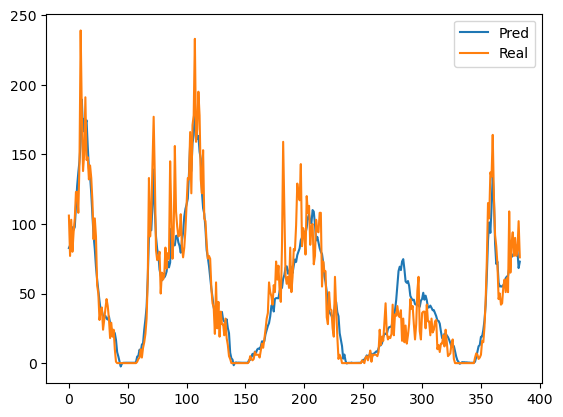

In [3]:

# 4. Initialiser le modèle
model = CNN(
    num_nodes=df.shape[1],  # Nombre de stations (N)
    seq_len=config["data"]["sequence_length"],
    cnn_config=config["cnn"]
)

# 5. Initialiser le Trainer
trainer = Trainer(model=model, dataloaders=dataloaders, config=config)

# 6. Lancer l'entraînement
trainer.train_and_valid()
print("-" * 30)

# 7. Faire des prédictions sur le jeu de test
test_predictions,real_values = trainer.predict(mode='test')
print(f"Dimensions des prédictions sur le jeu de test: {test_predictions.shape}")

print('\nPlot predictions vs real values')
pd.DataFrame(dict(Pred = test_predictions.detach().cpu().numpy()[:,0,0],
                  Real = real_values.detach().cpu().numpy()[:,0,0])
                  ).iloc[:96*4].plot()

# Historical data-based method:
Suppose que les données de trafic suivent une distribution avec des pattern qui se répètent à travers le temps. Ayant des périodicité, on peut les regrouper par classes calendaire. Par exemple qui partagent le tuple `(weekday, hour, minutes)`. Le PI serait basé sur les distributions des représentant d'une même classe, dans la dataset de train.

Le PI est alors $$[\mu_{i}^{t} - \alpha * \sigma_{i}^{t} , \mu_{i}^{t} + \alpha * \sigma_{i}^{t}] \phantom{abc} \forall i,t \in \mathcal{N}\times \mathcal{T} $$

Avec : 
- $\mathcal{N}$ l'ensemble des unités spatiales considérés (ex : les 40 stations de métro)
- $\mathcal{T}$ l'ensemble des classes temporelles (ex : l'ensemble des lundi 8:30)
- $\alpha$ un coefficient qui sert de sueil (1*std ou 3*std)



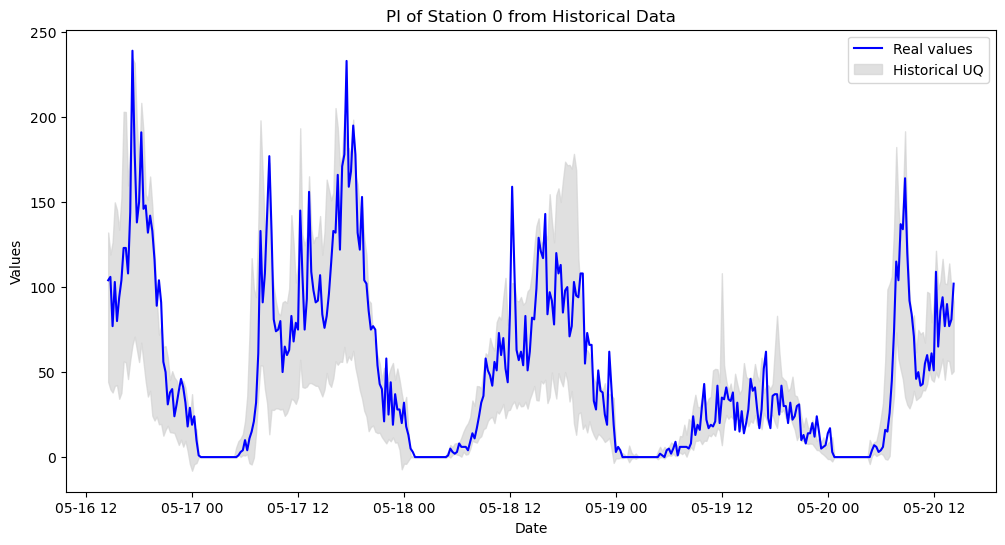

In [5]:
from historical_method import get_stats_agg_per_calendar_group,get_upper_and_lower_bounds
from plotting import plot_PI_from_historical_UQ

## Split Raw DataFrame to extract Train Set and get statistics from it :
train_prop = 1-config["data"]["test_size"]-config['data']['valid_size']
n_train = int(len(df) * train_prop)
init_test = int(len(df) * (1-config["data"]["test_size"]))
train_df = df.iloc[:n_train,:]
test_df = df.iloc[init_test:,:]
df_stats = get_stats_agg_per_calendar_group(train_df,method = 'week and hour',time_step_per_hour = 4)

## Get Lower and Upper band associated to mean and std of the historical data
real,lower,upper = get_upper_and_lower_bounds(df_stats,test_df,station_i)

## Plot PI 
plot_PI_from_historical_UQ(real,lower,upper, station_i=0)

# Deep Ensemble 
L'idée est d'utiliser la prédiction d'un $\textit{ensemble}$ de modèles qui ont tous été entrainé avec la même configuration mais dont les initialisations diffèrent.

On veut quantifier l'incertitude du modèle sur la prédiction. On peut donc définir la "bande d'incertitude" de l'ensemble.

Une manière simple est de regarder la moyenne des prédiction, avec $\pm \lambda$ std

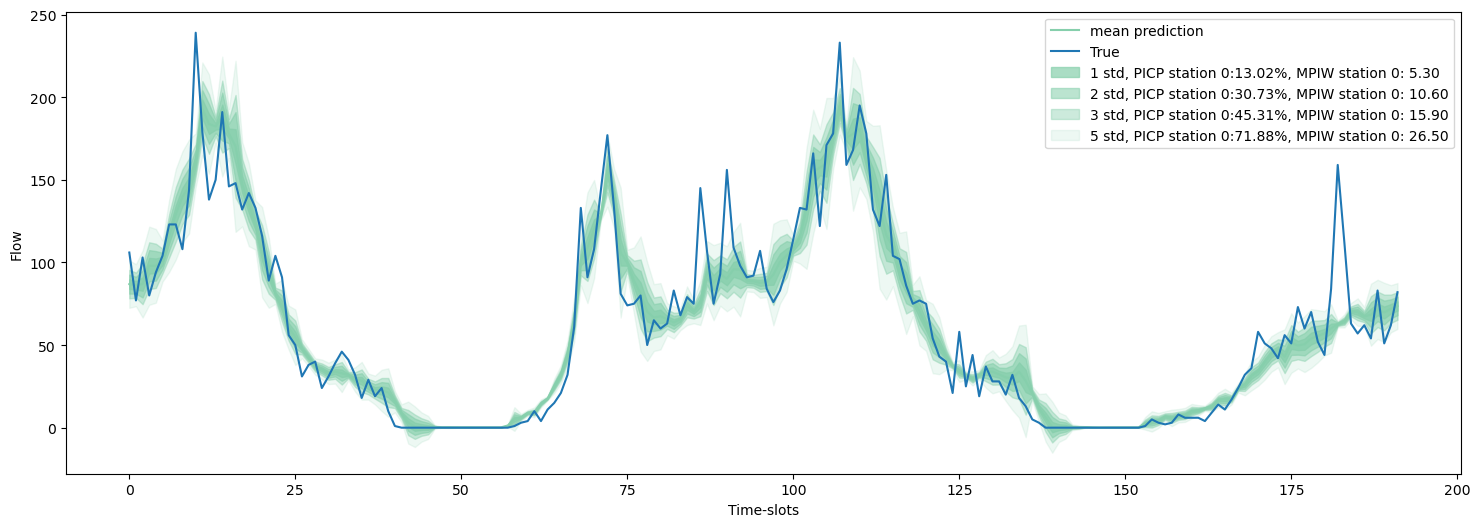

In [6]:
from load_model import DeepEnsemble


ensemble_size = 3
Trainers = [Trainer(model = CNN(num_nodes=df.shape[1], 
                                seq_len=config["data"]["sequence_length"],
                                cnn_config=config["cnn"]), 
                    dataloaders=dataloaders, 
                    config=config )
                      for _ in range(ensemble_size)]
deepensemble = DeepEnsemble(Trainers)

deepensemble.train_and_test_n_times()
deepensemble.plot_spatial_unit_i(station_i=0, window_pred = np.arange(2*96), method = 'std_range', Lambda_coeffs =[1,2,3,5])

# Monte Carlo Dropout
La technique précédente de l'ensemble Learning est efficace pour retranscrire l'incertitude d'un model sur une prédiction et la stabilité (ou instabilité) de son entrainement, mais elle est très couteuse. 

La Monte Carlo Dropout propose d'utiliser une architecture avec des dropout, et une fois qu'elle est entrainée, utiliser le test avec les dropouts actifs. Il suffit alors de générer une centaine de test, sur ce même modèle déjà entrainé. 

**Limites et Discussions** 
- A chaque prédction, on bride le modèle puisqu'on y affecte un certain dropout. Ainsi on pourrait dire qu'on 'limite les performances du modèles' à chaque inférence.
- Il y a également des problèmes de définition mathématiques de l'incertitude. Aleatoric et Epistemic Uncertainty ne sont pas définies rigoureusement. Il y a une discussion a ce propopos [reddit](https://www.reddit.com/r/MachineLearning/comments/7bm4b2/d_what_is_the_current_state_of_dropout_as/), où ils parlent de Risk et d'Uncertainty, de ce qui est capturé par le MC dropout, et de leur différences. Risk et Uncertainty sont deux choses fondamentalements différentes, que l'on peut définir précisément dans le contexte de la Bayesian Inference. [Gal & Ghahramani, 2016](https://arxiv.org/pdf/1506.02142.pdf) ont considérés que le test-time dropout pouvait être considéré comme une Baysian approximation. [Osband 2016](http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf) a publié une note, et utilise une [figure](http://htmlpreview.github.io/?https://github.com/yaringal/HeteroscedasticDropoutUncertainty/blob/master/demos/homoscedastic_dropout_reg_DM_relu.html) intéressante. Il explique que de nombreuses méthodes présentée comme approximation de l'uncertainty d'un model sont en fait une approximation du risk du model. Il discute aussi de la différence entre distribution à posteriori de la moyenne, et distribution de la sortie d'un model. Il identifique :
    - le risk comme quelque chose d'inhérent à la stochasticité du model   (Le lancé d'une pièce présente un risque, une chance sur deux pour être 0 ou 1, et alors un agent apprenant - lanceur ou model ?-  peut être incertain de p)
    - l'uncertitude comme une confusion sur les paramètres que l'ont devrait fixer au model (l'incertitude capture la la variabilité de la croyance (à posteriori) du lanceur, et elle peut être résolue par une analyse stat des données)
    -Dans le cas du lancé de pièce, avec une modélisation plus détaillée de la physique/dynamique derrière le lancé de pièce, on peut réduire le risque, et il peut n'être plus risqué du tout.


- Activation des Dropout avec model.train() au lieu de model.eval(): solution la plus simle pour activer les dropouts, mais j'active aussi ici les autres régularisations, que je ne veux pas forcément.

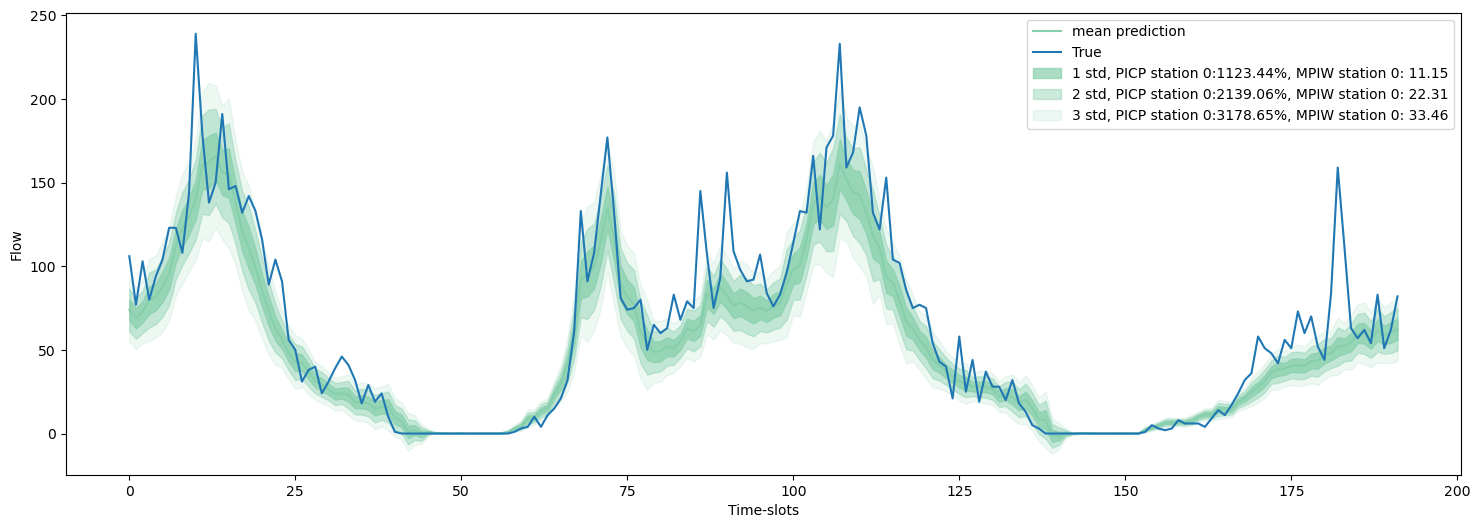

In [7]:
from plotting import plot_uncertainty_bands

nb_inferences = 100
station_i  = 0 
L_preds = []
for _ in range(nb_inferences): 
    test_predictions,real_values = trainer.predict(mode='test',allow_dropout = True)
    L_preds.append(test_predictions.squeeze())

plot_uncertainty_bands(L_preds,real_values,station_i=0,window_pred = np.arange(2*96))

## Deep Quantile Regression (DQR) ou  Quantile Regression (QR):
Ici, le modèle sert de **quantile estimator**.
- Au lieu de prédire une seule sortie (la moyenne),**on prédit autant de sorties que de quantiles désirés**. Par exemple, pour un intervalle de prédiction à 90%, on prédira deux valeurs : le quantile à 5% ($\alpha=0.05$) et le quantile à 95% ($\alpha=0.95$)
- **On adapte la fonction objective**, qui minimisera la moyenne des erreur faite sur chacune des sorties. On n'utilise plus la MSE (ou autre HuberLoss, MAE...) mais la `Pinball Loss`, une fonction objective conditionnelle où chaque sortie d'erreur est associé à un quantile. 

## La "Pinball Loss"

Pour un quantile cible $\alpha \in (0, 1)$, la perte pour une prédiction $\hat{y}$ et une valeur réelle $y$ est définie par :
$$
    L_{\alpha}(y, \hat{y}) = 
    \begin{cases} 
        \alpha (y - \hat{y}) & \text{si } y \ge \hat{y} \quad \text{(sous-estimation)} \\ 
        (1-\alpha)(\hat{y} - y) & \text{si } y < \hat{y} \quad \text{(sur-estimation)} 
    \end{cases}
$$

Exemple : prenons le quantile $\alpha$ = 0.1
- Si le modèle `sous-estime` la vraie valeur ($y > \hat{y}$), la perte est $L = 0.1 \times (y - \hat{y})$. La pénalité est `faible`.
- Si le modèle `sur-estime` la vraie valeur ($y < \hat{y}$), la perte est $L =  0.9 \times (\hat{y}- y)$. La pénalité est `forte`.

Pour minimiser cette perte, le modèle est donc fortement incité à prédire une valeur $\hat{y}$ qui est inférieure à la vraie valeur $y$ environ 90% du temps, ce qui est exactement la définition du 10ème percentile. On remarque ici que les deux cas on doit minimiser un objet proportionnel à l'écart absolue $|y-\hat{y}|$, qui est l'estimateur de la médiane. On notera que la médiane est plutôt robuste aux outliers contrairement à la MSE qui est l'estimateur de la moyenne et sensible aux outliers.

Dans le cas où on estime plus de deux quantile, la fonction objective sera simplement la somme ou la moyenne des pertes calculées pour chaque quantile.


Quantiles utilisés pour les prédictions :  [0.025, 0.1, 0.5, 0.9, 0.975]
Dimensions des prédictions: torch.Size([1478, 40, 5])


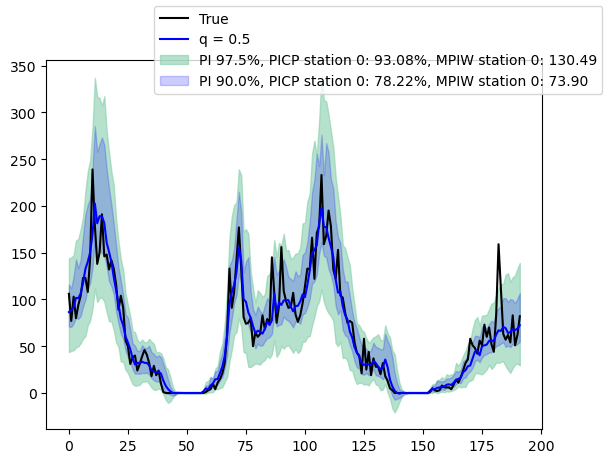

In [8]:
from plotting import plot_DQR

# 1. Modification de la loss function 
config['training']['loss_function'] = 'quantile'  

# 2. Detail explicite des quantiles à prédire : 
config['training']['quantile_list'] = [0.025,0.1,0.5,0.9,0.975]  # Est prioritaire sur config['training']['alpha'] et config['training']['nb_quantiles']


# 3. Load mode, train model, et prediction sur le test set : 
trainer = Trainer(model = CNN(num_nodes=df.shape[1], 
                                seq_len=config["data"]["sequence_length"],
                                cnn_config=config["cnn"],
                                nb_quantiles = len(config['training']['quantile_list']),
                                ),
                    dataloaders=dataloaders, 
                    config=config )
trainer.train_and_valid()
test_predictions,real_values = trainer.predict(mode='test')
print('\nQuantiles utilisés pour les prédictions : ', config['training']['quantile_list'])
print(f"Dimensions des prédictions: {test_predictions.shape}")

# 4. Plot des quantiles et réalisation du PI:
plot_DQR(test_predictions,real_values,config['training']['quantile_list'],station_i)


# Inductive Conformal Prediction: 
Approche statistique de l'Uncertainty quantification [Vovk et al., 2008](https://www.jmlr.org/papers/volume9/shafer08a/shafer08a.pdf).

L'inductive Conformal Prediction se fait après le total entrainement du modèle.  Elle est **inductive** par opposition à la **Transductive conformal prediction**. Dans l'inductive on entraine notre modèle pour qu'il nous fournisse la 'règle' derrière la distribution des donnée. On applique ensuite sur la test set pour obtenir les prédiction. Toutes les informations nécessaire sont contenues dans le modèle, et le training set n'intervient plus lors de la prédiction du test set. Dans le cas de la transductive inference, on prend un sample de test, et le training set nous oriente sur la prédiction.

**|!| Apparemment il y a aussi une difference entre 'split'/'inductive' et 'full' method. Dans [Romano, Patterson, Candès, May 2019](https://arxiv.org/pdf/1905.03222.pdf) ils écrivent : 'we will restrict our attention to split conformal prediction and refer the reader to [3, 15] for a more detailed comparison between the two methods [Lei, 2017, Book](https://arxiv.org/pdf/1604.04173.pdf) et [Vovk et al., 2005, Book](https://www.researchgate.net/publication/223460765_Algorithmic_Learning_in_a_Random_World)'** Par exemple, l'algo de la 'full' conformal prediction doit traiter les données de manière interchangeable.

Méthode : 
---
Permet de construire des bandes d'incertitudes autour de nos prédictions, sans modifier la prédiction du modèle. C'est obtenu en comparant les True / Predicted Values sur un certain ensemble de donnée. On en déduit un quantile empirique. A la comparaison entre la valeur prédite et la valeur réelle on y attribut un score, le 'conformity score', d'où le nom de la méthode.

On veut que pour chaque test sample $(X_{n+1},Y_{n+1})$: 
$$ \mathbb{P}(Y_{n+1} \in \hat{C}(X_{n+1})) \ge 1-\alpha$$

C'est à dire, que dans plus de $(1-\alpha)\%$ des cas, notre bande d'incertitude $\hat{C}$ autour de la prédiction, contient $Y_{n+1}$

## Split de la donnée : Proper/Calib/Valid/Test
Le set de donnée est séparée en plusieurs partie.
- **Training set** qui est lui même split en :
    - Proper Training set  $\mathcal{D}_1 = \{(X_i,Y_i),i\in \mathcal{I_1} \}$
    - Calibration set (un type de set de validation) $\mathcal{D}_2 = \{(X_i,Y_i),i\in \mathcal{I_2} \}$
- **Validation set** $\mathcal{D}_3 = \{(X_i,Y_i),i\in \mathcal{I_3} \}$
- **Test set** $\mathcal{D}_4 = \{(X_i,Y_i),i\in \mathcal{I_4} \}$
- $\mathcal{D}_1,\mathcal{D}_2,\mathcal{D}_3,\mathcal{D}_4$ forment une partition de l'ensemble des couples (séquences d'entrainement, valeur réelle).
    
Le Calibration set est généralement un set randomly selected. 

<!-- ## Conformal prediction procedure : 
- On défini le **conformity scores**, qui est ici simplement le residuel : $y - \hat{y}$
- On choisi le quantile $q \in [0,1]$
- On compute le quantile tensor, et il servira à définir la bande sup et bande inf de notre prédiction.

On imagine faire la quantile regression non pas pour l'ensemble des time-slots, mais seulement sur des groupes de times-slots 'critiques' (i.e clustering sur le calendrier, lié à des évenements et/ou des stations ...) -->

## Focus sur la 'split conformal prediction' 
tiré de [Romano, Patterson, Candès, May 2019](https://arxiv.org/pdf/1905.03222.pdf).

Soit $\mathcal{A}$ un algo de regression, le modèle de regression est entrainé sur le proper training set  : $$\hat{\mu}(x) \longleftarrow \mathcal{A}(\{(X_i,Y_i),i\in \mathcal{I}_{1} \})$$

Une fois l'algorithme entrainé, calcul les `absolute residuals` sur la Calibration set $\mathcal{I}_2$ . Cela permet de rendre compte de l'erreur médiane du modèle de régression : $$R_{i} = |Y_i - \hat{\mu} (X_i)|,\phantom{abc} i\in \mathcal{I}_2$$

On à donc un ensemble de résidual $\{R_i, i\in \mathcal{I}_2\}$ de cardinal $|\mathcal{I}_2|$ sur lequel on va récupérer des indicateur statistiques : pour $\alpha \in [0,1]$, on calcule le quantile d'ordre $1-\alpha$ de la distribution empirique des absolute residuals : $$Q_{1-\alpha}(R,\mathcal{I}_2) = (1-\alpha)\left( 1+\frac{1}{|\mathcal{I}_2 |} \right) ^{th}\text{ quantile empirique de } \{R_i, i\in \mathcal{I}_2\} $$ 

Et alors, on déduit le PI pour un nouveau point $X_{n+1}$ en tant qu'interval de largeur $2Q_{1-\alpha}$ et centré sur $\hat{\mu}$:  $$C(X_{n+1}) =[\hat{\mu}(X_{n+1}) - Q_{1-\alpha}(R,\mathcal{I}_2),\phantom{a} \hat{\mu}(X_{n+1}) + Q_{1-\alpha}(R,\mathcal{I}_2)]  $$
Cet interval [satisfait l'hyppothèse de recouvrement](https://www.researchgate.net/publication/223460765_Algorithmic_Learning_in_a_Random_World) $\mathbb{P}\{Y \in \hat{C}(x) | X=x \} \ge 1-\alpha $. Cependant, il est largement limité dans le sens où la largeur de l'interval est indépendant des variations de $X_{n+1}$. Ce qui amène [Romano, Patterson, Candès, May 2019](https://arxiv.org/pdf/1905.03222.pdf) à proposer la Conformalized Quantile Regression (CQR), dont la largeur de l'interval serait variable.
 



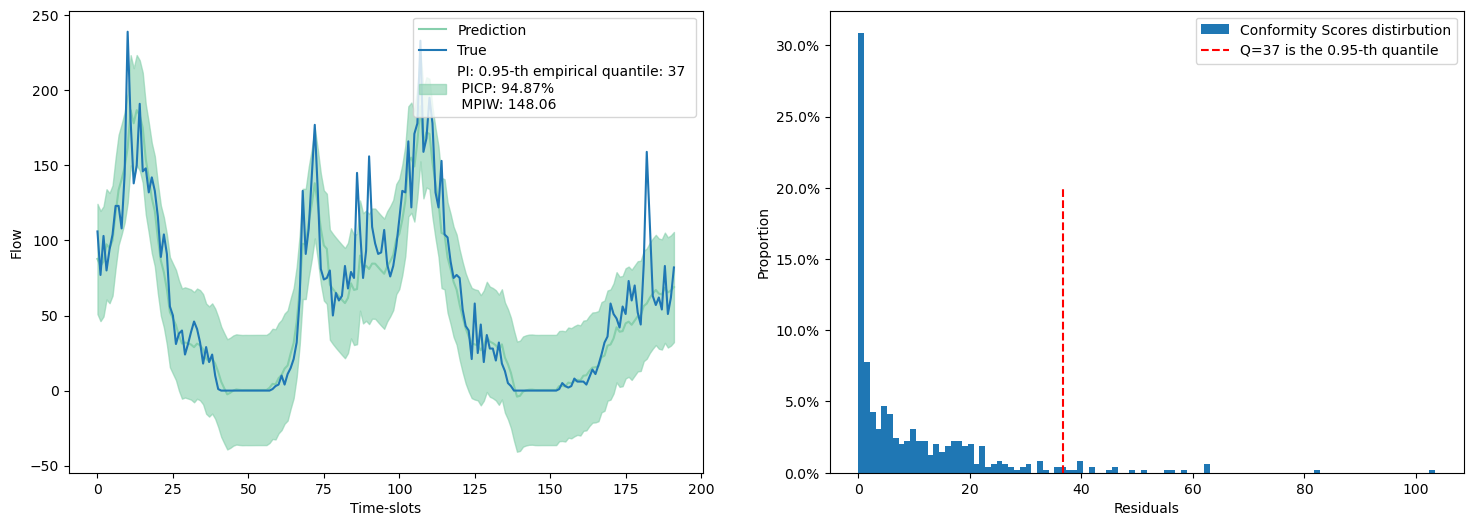

In [10]:
from plotting import plot_conformal_bands
from PI import PI_object


trainer = Trainer(model = CNN(num_nodes=df.shape[1], 
                                seq_len=config["data"]["sequence_length"],
                                cnn_config=config["cnn"],
                                ),
                    dataloaders=dataloaders, 
                    config=config )
trainer.train_and_valid()
calibrator = trainer.conformalize_calibration()

Q = calibrator.Q
Q = Q.detach().cpu()
test_predictions,real_values = trainer.predict(mode='test')

# PI 
bands = torch.cat([test_predictions-Q.unsqueeze(-1), test_predictions+Q.unsqueeze(-1)], dim=-1)  ## Bands from Predictions calibreated with +/- Q
pi = PI_object(bands, real_values, type_calib = 'classic',Q=Q)

plot_conformal_bands(test_predictions,real_values,station_i,
                     q_order = calibrator.quantile_order,
                     pi = pi,
                     conformity_scores = calibrator.conformity_scores,
                     bins = 100)

## Conformalized Quantile Regression
Provient d'un article de math [Romano, Patterson, Candès, May 2019](https://arxiv.org/pdf/1905.03222.pdf). Ils ont pour but de construire un 'marginal distribution-free prediction interval' avec un taux d'erreur controlé (1-$\alpha$)

**Dans leur papier, il ne parlent uniquement de prediction intervalle, mais pas de PI ou de Probability Interval**

Lorsqu'ils parlent de 'Deep Quantile Regression (DQR)' dans [Adaptive Modeling of Uncertainties for Traffic Forecasting, Ying Wu et al., 2023](https://arxiv.org/pdf/2303.09273.pdf), c'est à celle-ci qu'ils font réferrence (même si pas extrêmement clair, peut être plutôt CQR...). 

C'est très inspiré de la **conformal prediction**. En fait ils combinent conformal prediction et quantile regression.
- Split le training set en 2 : proper training set $\mathcal{I_1}$ et calibration set $\mathcal{I_2}$
- Entrainent 2 quantile regressor (un pour lower band et l'autre pour upper band du PI)
- Ensuite, en s'aidant du calibration set, ils 'conformalize', et donc si nécessaire ils corrigent le PI. Ce nouvel intervalle (contrairement a celui généré initialement) garanti de vérifier l'hyppothèse de recouvrement (quelque soit le choix d'estimateur de quantile regressor ou de son accuracy) : $$\mathbb{P}\{Y_{n+1} \in C(X_{n+1}) \} \ge 1-\alpha$$
- Diffère de la conformal prediction dans le sens où ils calibrent le PI en utilisant un **conditional quantile** regression (là où la méthode standard utilise conditional mean regression)

Le but de la Conditional Quantile Regression est d'estimer un certain quantile (mediane, 0.90 etc) de Y conditionnellement à X. On appel F la **conditional distribution function**  de Y sachant X:
$$F(y | X = x) = \mathbb{P} \{ Y \leq y |  X = x \} $$
Et la **$\alpha^{th}$ conditional quantil function** est : 
$$ q_{\alpha}(x) = \inf \{y \in \mathbb{R}, F(y|X=x) \ge \alpha  \}$$
Alors, en fixant $\alpha_{l} = \alpha /2$ et $\alpha_{u} = 1- \alpha /2$, on défini un Interval de prédiction à $1-\alpha \%$  (ou à taux d'erreur $\alpha$ / PI for Y given X=x, with miscoverate rate $\alpha$ )
$$ C(x) = [ q_{\alpha_{l}}(x),q_{\alpha_{u}}(x) ]$$

Par construction, l'intervale $C(x)$ vérifie : 
$$\mathbb{P}\{Y \in C(x) | X=x \} \ge 1-\alpha $$

Comme tout est conditionnellement à $X$, la largeur de l'interval $C$ dépend de X, et l'incertitude sur Y est exprimé par la largeur de l'interval.

Méthode de construction :
-----
Soit $\mathcal{A}$ un algo de quantile regression, on entraine 2 Conditional Quantile Function $\hat{q}_{\alpha_l}$ et $\hat{q}_{\alpha_u}$ sur $\mathcal{I_1}$ :$$\{\hat{q}_{\alpha_l},\hat{q}_{\alpha_u} \} \longleftarrow \mathcal{A}(\{(X_i,Y_i),i\in \mathcal{I}_{1} \})$$
On calcul ensuite les **conformity scores** pour quantifier les erreurs faites par le PI estimé $\hat{C}(x)$ : $$E_{i} = \max \{ \hat{q}_{\alpha_l}(X_i)- Y_i, Y_i - \hat{q}_{\alpha_u}(X_i) \} $$  
Dans le cas où $Y_i$ est dans l'intervalle $[\hat{q}_{\alpha_l}(X_i), \hat{q}_{\alpha_u}(X_i)]$, le conformity score est négatif, sinon il est positif. 

Et alors, on défini $Q_{1-\alpha}(E,\mathcal{I}_2)$ comme dans la conformal prediction : 
$$Q_{1-\alpha}(E,\mathcal{I}_2) = (1-\alpha)\left( 1+\frac{1}{|\mathcal{I}_2 |} \right) ^{th}\text{ quantile empirique de } \{E_i, i\in \mathcal{I}_2\} $$ 

On produit alors le PI $C(X_{n+1})$ :
$$C(X_{n+1}) = [\hat{q}_{\alpha_l}(X_{n+1})- Q_{1-\alpha}(E,\mathcal{I}_2),\phantom{a} \hat{q}_{\alpha_u}(X_{n+1})+Q_{1-\alpha}(E,\mathcal{I}_2) ] $$ 

La largeur de l'interval est d'au moins $2Q_{1-\alpha}(E,\mathcal{I}_2)$, mais au moins les bornes $\hat{q}_{\alpha_l}$ et $\hat{q}_{\alpha_u}$ ne sont pas d'écarts constant. Et cela [satisfait l'hyppothèse de recouvrement](https://arxiv.org/pdf/1905.03222.pdf) $\mathbb{P}\{Y \in \hat{C}(x) | X=x \} \ge 1-\alpha $

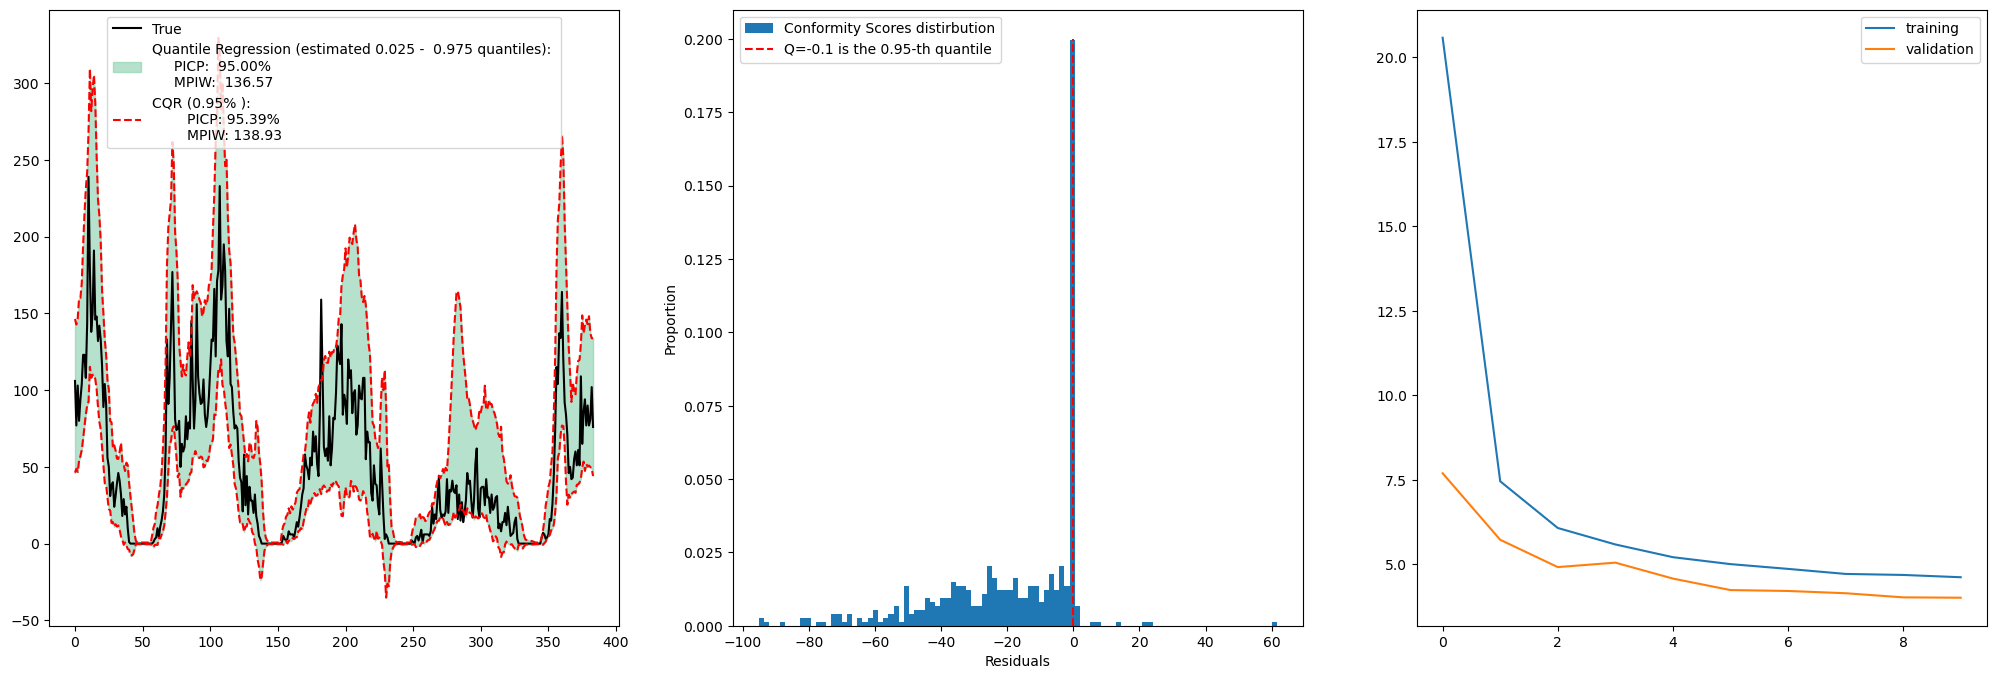

In [4]:
from plotting import plot_bands_CQR

# Init 
station_i = 0  # Focus sur la première station (Ampère)
alpha = 0.05
nb_quantiles = 2
# ----


# 1. Modification de la loss function 
config['training']['loss_function'] = 'quantile'  

# 2. Detail explicite des quantiles à prédire : 
if 'quantile_list' in config['training'].keys():
    del config['training']['quantile_list']  # On supprime la liste des quantiles si elle existe déjà
config['training']['alpha'] = alpha  # Est prioritaire sur config['training']['alpha'] et config['training']['nb_quantiles']

# 3. Load mode, train model, et prediction sur le test set : 
trainer = Trainer(model = CNN(num_nodes=df.shape[1], 
                                seq_len=config["data"]["sequence_length"],
                                cnn_config=config["cnn"],
                                nb_quantiles = nb_quantiles,
                                ),
                    dataloaders=dataloaders, 
                    config=config )

trainer.train_and_valid()
calibrator = trainer.conformalize_calibration()

Q = calibrator.Q
test_predictions,real_values = trainer.predict(mode='test')

# PI 
pi_CQR = PI_object(test_predictions, real_values, type_calib = 'CQR',Q=Q)

plot_bands_CQR(trainer,real_values,test_predictions,pi_CQR,
                alpha=alpha,
                conformity_scores = calibrator.conformity_scores,
                station_i  = station_i, bins = 100)

# La Suite n'a pas été review: 

## Quantile Estimation from Data
Généralement, on estime la **moyenne d'une prédiction conditionnellement à ses données**  en minimisant la somme des carrés des residuals des points d'entrainement : 
$$ \hat \mu (x) = \mu(x,\hat{\theta}) $$
$$ \hat{\theta} = \argmin\limits_{\theta} \frac{1}{n} \sum\limits_{i=1}^{n} (Y_{i} - \mu(X_{i},\theta))^{2} + \mathcal{R}(\theta)$$
où $\theta$ représente les paramètres du modèle, $\mu (x,\theta)$ la fonction de regression, $\mathcal{R}$ représente une régularisation (potentielle)

De manière analogue, on peut estimer une conditional quantile function $q_{\alpha}$ de Y sachant X=x  : 
$$\hat q_{\alpha}(x) = f(x,\hat{\theta}) $$
$$ \hat{\theta} = \argmin\limits_{\theta} \frac{1}{n} \sum\limits_{i=1}^{n} \rho _{\alpha}(Y_{i}, f(X_{i},\theta)) + \mathcal{R}(\theta)$$
où $f(x,\theta)$  représente la quantile regression function, et $\rho _{\alpha}$ est la losse function, (appelé 'pinball loss' ou 'check function').
$$ \rho = \alpha (y-\hat{y}) \text{ si } y-\hat{y} > 0\text{, et }(1-\alpha)*(\hat{y}-y)\text{ sinon} $$

Cela permet d'avoir une estimation de l'intervalle de prédiction $\hat{C}(x)$:
$$\hat{C}(x) = [\hat{q}_{\alpha_{l}}(x), \hat{q}_{\alpha_{u}}(x)] $$

**Limites** : l'hyppothèse de recouvrement $\mathbb{P}\{Y \in \hat{C}(x) | X=x \} \ge 1-\alpha $ n'est pas garanti. 

# [QuanTraffic](https://github.com/wuyingvia/QUANTRAFFIC/blob/151a83dfb260732c2e19215f3c3c8cf3190f72b7/main.py#L161)
Etapes de train, valid, calib : 
---
 - Train_valid complètement le model :
       en sauvegardant la meilleur valid, Quantile Loss, et optimizer Adam ou RMSprop)
 - Calibre le model : 
        - Load le meilleur modèle retenu lors du train_valid 
        - Fait la prédiction du PI sur Calibration set (YS_pred_0 et YS_pred_1) + unormalize les predictions. 
            - Les deux bornes sont séparée en YS_0_train, YS_1_train en prenant la première moitiée des éléments de YS_pred_0 et de YS_pred_1. YS_train  est également construit (contenant les deux bornes)
            - Ainsi qu'en YS_0_val, YS_1_val en prenant la seconde moitiée des éléments de YS_pred_0 et de YS_pred_1. YS_val  est également construit (contenant les deux bornes)
        - On calcule ensuite les residuals de  YS_0_train, YS_1_train par rapport à YS_train  (donc écart sur upper et lower band), puis concatene (récupere dim = 2, lower et upper)  [2*len_calib, Channel, Nodes]
        - Produit une 'corr_err_list' de dimension [n_grid+1, Channel, Nodes]  (3,C,N ???) qui contient l'ensemble des quantiles  torch.quantile(residual(c,n), alpha),  == calculé sur l'ensemble des time-slots ==
        
 - Test le model 


In [18]:
def split_true_pred_and_get_residuals(YS,YS_pred):
    YS_pred_0 = YS_pred[..., 0]
    YS_pred_1 = YS_pred[..., 1]
    print('YS_pred_0.shape, YS_pred_1.shape,', YS_pred_0.shape, YS_pred_1.shape)

    YS, YS_pred_0, YS_pred_1 = np.squeeze(YS), np.squeeze(YS_pred_0), np.squeeze(YS_pred_1)
    print('\n np.squeeze: \n YS.shape, YS_pred_0.shape, YS_pred_1.shape', YS.shape, YS_pred_0.shape, YS_pred_1.shape)

    # split some data
    split = int(YS.shape[0]* 0.5)

    YS_train = YS[:split]
    YS_0_train = YS_pred_0[:split]
    YS_1_train = YS_pred_1[:split]
    print('\n \n Split: \n YS_train.shape, YS_0_train.shape, YS_1_train.shape,',YS_train.shape, YS_0_train.shape, YS_1_train.shape)

    YS_val = YS[split:]
    YS_0_val = YS_pred_0[split:]
    YS_1_val = YS_pred_1[split:]
    print('YS_val.shape, YS_0_val.shape, YS_1_val.shape,',YS_val.shape, YS_0_val.shape, YS_1_val.shape)

    YS_1_train = YS_1_train * (YS_1_train>0)  
    print('\n \n Mask negative values: \n YS_1_train.shpae', YS_1_train.shape)

    error_low =  YS_train - YS_1_train
    error_high =  YS_0_train - YS_train
    err_dis = torch.cat([error_low,error_high])
    print('\n \n Compute error: \n err_dis.shape, error_low.shape, error_high.shape ', err_dis.shape, error_low.shape, error_high.shape)

    return(err_dis,YS,YS_pred_0,YS_pred_1,YS_val,YS_0_val,YS_1_val)

def get_corr_err(err_dis,error_quantile = 99, node = 40, channel = 3):
    ''' For each quantile slots :
    - Compute quantile of each tuple (Channel, Node) sur les residuals 'err_dis'. Calcule le quantile l'ensemble des time-slots. 
    - Then compute the percentage coverage and the mean length of PI thank to the upper band, lower band, and the True Value
    '''
    # return [error_q, seq, node]
    corr_err_list = []
    for q in range(0, error_quantile+1):
        q_n = []
        for n in range(node):
            q_t = []
            for t in range(channel):
                corr_err = torch.quantile(err_dis[:, t, n], q/error_quantile)
                q_t.append(corr_err)
            q_t = torch.stack(q_t)
            q_n.append(q_t)
        q_n = torch.stack(q_n).T
        corr_err_list.append(q_n)
    corr_err_list = torch.stack(corr_err_list)
    corr_err_list.size()
    return(corr_err_list)

def get_coverage_and_interval_len(YS,YS_pred_0,YS_pred_1,corr_err_list,n_quantile):
    ''' For each quantile :
    - Compute the upper and lower band of the prediction (according to the result predicted and the 'corr_err_list')
    - Then compute the percentage coverage and the mean length of PI thank to the upper band, lower band, and the True Value
    '''

    coverage_list = []
    interval_list = []
    for m in range(0, n_quantile+1):
      y_u_pred = YS_pred_0 + corr_err_list[m]
      y_l_pred = YS_pred_1 - corr_err_list[m]
      y_l_pred = y_l_pred * (y_l_pred >=0)
      mask = YS > 0

      coverage = torch.logical_and(y_u_pred >= YS, y_l_pred <= YS)
      coverage_a = torch.mean(coverage.float(),axis=0)
      coverage_list.append(coverage_a)
      interval_a = torch.mean(torch.abs(y_u_pred - y_l_pred),axis=0)       
      interval_list.append(interval_a)

    # torch.Size([sample, channel, node])
    coverage_list = torch.stack(coverage_list)
    interval_list = torch.stack(interval_list)

    print('\n \n coverage_list.shape, interval_list.shape: ',coverage_list.shape,interval_list.shape)
  
    return(coverage_list,interval_list)


def minmax_norm_coverage_and_interval(coverage_list,interval_list,node = 40, channel = 3):
    interval_nor = []
    for n in range(node):
        interval_n = []
        for t in range(channel):
            interval_ = (interval_list[:,t, n] - torch.min(interval_list[:,t, n])) /\
                        (torch.max(interval_list[:,t, n]) - torch.min(interval_list[:,t, n]))
            interval_n.append(interval_)
        interval_n = torch.stack(interval_n)
        interval_nor.append(interval_n)
    interval_nor = torch.stack(interval_nor).T

    coverage_nor = []
    for n in range(node):
        coverage_n = []
        for t in range(channel):
            coverage_ = (coverage_list[:,t, n] - torch.min(coverage_list[:,t, n])) /(
                    torch.max(coverage_list[:,t, n]) - torch.min(coverage_list[:,t, n]) + 1e-5)
            coverage_n.append(coverage_)
        coverage_n = torch.stack(coverage_n)
        coverage_nor.append(coverage_n)
    coverage_nor = torch.stack(coverage_nor).T 
    print('\n \n coverage_nor.shape, interval_nor.shape: ',coverage_nor.shape, interval_nor.shape)
    return(coverage_nor,interval_nor)

def get_calibration_table_according_different_lambda(corr_err_list,lambda_list,node = 40, channel = 3):
    cor_err = []
    lambda_list = torch.Tensor(lambda_list)
    for i in lambda_list:
        loss = - i * coverage_nor + (1 - i) * interval_nor
        index = torch.argmin(loss,axis=0).cpu().numpy() # l'index correspond à la quantile calibration qui donne la loss minimale
        err_t = []
        for t in range(channel):
            err_n = []
            for n in range(node):
                corr_err = corr_err_list[index[t,n], t, n]
                err_n.append(corr_err)
            err_n = torch.stack(err_n)
            err_t.append(err_n)
        err_i = torch.stack(err_t)
        cor_err.append(err_i)
    cor_err = torch.stack(cor_err)
    return(cor_err)

def get_best_index_associated_to_best_lambda(cor_err,YS_val,YS_0_val,YS_1_val,lambda_list,exp_q):
    # 选择期望的cor_err
    independent_coverage_l =[]
    for i in range(len(lambda_list)):
        y_u_pred = YS_0_val + cor_err[i]
        y_l_pred = YS_1_val - cor_err[i]

        y_l_pred = y_l_pred * (y_l_pred>0)
        mask = YS_val>0
        independent_coverage = torch.logical_and(torch.logical_and(y_u_pred >= YS_val, 
        y_l_pred <= YS_val), mask)
        m_coverage = torch.sum(independent_coverage)/torch.sum(mask)
        independent_coverage_l.append(m_coverage)
    m_coverage = torch.stack(independent_coverage_l)
    index = torch.argmin(torch.abs(m_coverage - exp_q))
    return(index)


# ===============================================================
# Application 
# ===============================================================
import torch
import numpy as np

n_quantile = 2 # ou 99

YS = torch.randn(32,3,40,1)
YS_pred = torch.randn(32,3,40,2)
print('YS.shape, YS_pred.shape,', YS.shape, YS_pred.shape)


# A la fin la 'calibration table' contient les residual values où l'index est la quantile calibration qui donne la loss minimale 
lambda_list = np.arange(0,41)/41   # Weight to control the balnce of PI and the coverage Ccov for a given node-prediction-window combination

err_dis,YS,YS_pred_0,YS_pred_1,YS_val,YS_0_val,YS_1_val = split_true_pred_and_get_residuals(YS,YS_pred)
corr_err_list = get_corr_err(err_dis,n_quantile)
coverage_list,interval_list = get_coverage_and_interval_len(YS,YS_pred_0,YS_pred_1,corr_err_list,n_quantile)
coverage_nor,interval_nor = minmax_norm_coverage_and_interval(coverage_list,interval_list,node = 40, channel = 3)
cor_err = get_calibration_table_according_different_lambda(lambda_list,node = 40, channel = 3)
index = get_best_index_associated_to_best_lambda(cor_err,YS_val,YS_0_val,YS_1_val,lambda_list,exp_q)

YS.shape, YS_pred.shape, torch.Size([32, 3, 40, 1]) torch.Size([32, 3, 40, 2])
YS_pred_0.shape, YS_pred_1.shape, torch.Size([32, 3, 40]) torch.Size([32, 3, 40])

 np.squeeze: 
 YS.shape, YS_pred_0.shape, YS_pred_1.shape torch.Size([32, 3, 40]) torch.Size([32, 3, 40]) torch.Size([32, 3, 40])

 
 Split: 
 YS_train.shape, YS_0_train.shape, YS_1_train.shape, torch.Size([16, 3, 40]) torch.Size([16, 3, 40]) torch.Size([16, 3, 40])
YS_val.shape, YS_0_val.shape, YS_1_val.shape, torch.Size([16, 3, 40]) torch.Size([16, 3, 40]) torch.Size([16, 3, 40])

 
 Mask negative values: 
 YS_1_train.shpae torch.Size([16, 3, 40])

 
 Compute error: 
 err_dis.shape, error_low.shape, error_high.shape  torch.Size([32, 3, 40]) torch.Size([16, 3, 40]) torch.Size([16, 3, 40])

 
 coverage_list.shape, interval_list.shape:  torch.Size([3, 3, 40]) torch.Size([3, 3, 40])

 
 coverage_nor.shape, interval_nor.shape:  torch.Size([3, 3, 40]) torch.Size([3, 3, 40])


## Bayesian Uncertainty Quantification: 
Vient de ce papier [Weight Uncertainty in Neural Networks, Blundell et al., 2015](https://arxiv.org/pdf/1505.05424.pdf)
- Modélise l'incertitude des paramètres du modèles en utilisant une fonction de vraissemblance. 
- Compute l'incertitude sur la donnée en approchant la distribution de proba sur les sortie du modèle

Dans le papier [Adaptive Modeling of Uncertainties for Traffic Forecasting, Ying Wu et al., 2023](https://arxiv.org/pdf/2303.09273.pdf) : consdièrent la distribution appriori comme loi normale (Gaussian priori distribution with 0 mean and 1 variance), et un MC sampling de 50.

## Variational Inference 
Essaye d'approximer la distribution à posteriori. En minimisant la Kullback-Leibler divergence entre la distribution estimée et la distribution a posteriori, on arrive a un problème d'optimisation. 

Méthode avec beaucoup de Biais, mais peut de ressource nécessaire.

## Markov Chaine Monte Carlo (MCMC)
Méthode sans biais, mais demande beaucoup de ressource